# Using Neural Network Formulations in OMLT

In this example we show how different neural networks can be formulated within Pyomo using OMLT. This notebook assumes you have a working tensorflow environment in addition to other necessary packages denoted below.

## Library Setup
Start by importing the libraries used in this project:

Base libraries used this notebook: <br>
- `numpy`, `pandas`: data manipulation <br>
- `json`: needed to write neural network parameters (e.g. scaling information) <br>
- `matplotlib`: used for plotting the results in this example

In this notebook we import a neural network into Pyomo from Keras (through tensorflow) to train a simple neural network. We consequently need working Pyomo and Tensorflow packages.
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `tensorflow`: the machine learning language we use to train our neural network

We import the following classes from OMLT:
 - `OmltBlock`: A Pyomo custom block that can represent machine learning models (such as neural networks)

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

import pyomo.environ as pyo
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, NeuralNetworkFormulation, ComplementarityReLUActivation
from omlt.io import keras_reader
import omlt

## Import the Data

We begin by training a neural network that learns some simulation data given by the following imported dataframe. The data contains a single input `x` and a single output `y` with 10,000 total samples

In [2]:
df = pd.read_csv("../data/sin_quadratic.csv",index_col=[0])
df

,x,y
0,-2.0000,4.566349
1,-1.9996,4.553958
2,-1.9992,4.539837
3,-1.9988,4.576585
4,-1.9984,4.574317
...,...,...
9995,1.9984,3.537576
9996,1.9988,3.542588
9997,1.9992,3.506658
9998,1.9996,3.489701


The data we use for training is plotted below (on the left figure). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the original data values (on the right).

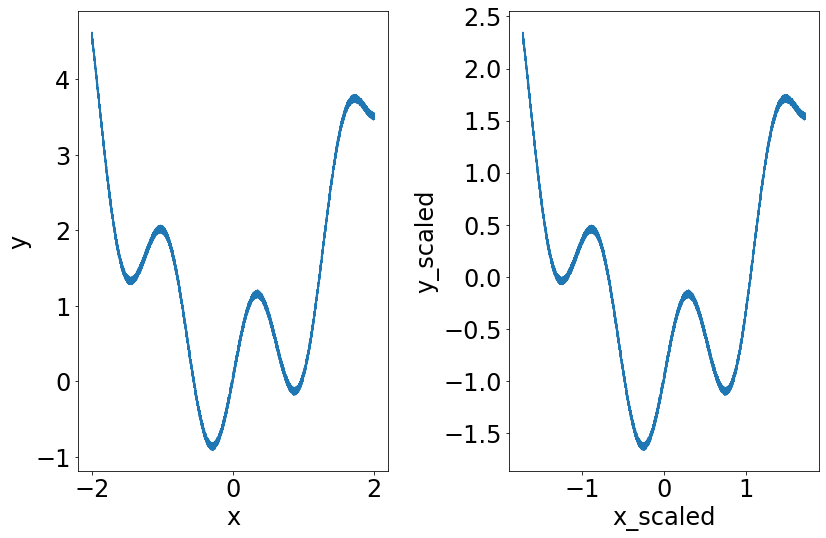

In [3]:
x = df["x"]
y = df["y"]

mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

f, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y");


ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled");

plt.tight_layout()

## Train the Neural Network
After importing the dataset we use keras to train three neural network models. Each neural network contains 2 layers with 100 nodes per layer with a single output layer. The first network (`model1`) uses relu activation functions, the second network (`model2`) uses sigmoid activatios, and the last network (`model3`) mixes relu and sigmoid activation functions. We use the ADAM optimizer and train each neural network for 100 epochs.

In [4]:
#relu neural network
model1 = Sequential(name='sin_wave_relu')
model1.add(Input(1))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer=Adam(), loss='mse')

#sigmoid neural network
model2 = Sequential(name='sin_wave_sigmoid')
model2.add(Input(1))
model2.add(Dense(100, activation='sigmoid'))
model2.add(Dense(100, activation='sigmoid'))
model2.add(Dense(1))
model2.compile(optimizer=Adam(), loss='mse')

#mixed neural network
model3 = Sequential(name='sin_wave_sigmoid')
model3.add(Input(1))
model3.add(Dense(100, activation='sigmoid'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer=Adam(), loss='mse')

In [8]:
history1 = model1.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=100)
history2 = model2.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=100)
history3 = model3.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=100)

Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 8.1870e-04
Epoch 2/100
313/313 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 8.5608e-04
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 8.3965e-04
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 8.3038e-04
Epoch 6/100
313/313 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7/100
313/313 [==============================] - 1s 2ms/step - loss: 8.1511e-04
Epoch 8/100
313/313 [==============================] - 0s 2ms/step - loss: 8.6481e-04
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 8.8677e-04
Epoch 10/100
313/313 [==============================] - 1s 2ms/step - loss: 7.7992e-04
Epoch 11/100
313/313 [==============================] - 1s 2ms/step - loss: 8.6002e-04
Epoch 12/100
313/313 [==============================] - 1s 2

313/313 [==============================] - 1s 2ms/step - loss: 7.0489e-04
Epoch 96/100
313/313 [==============================] - 1s 2ms/step - loss: 7.1746e-04
Epoch 97/100
313/313 [==============================] - 1s 2ms/step - loss: 7.9408e-04
Epoch 98/100
313/313 [==============================] - 1s 2ms/step - loss: 7.5925e-04
Epoch 99/100
313/313 [==============================] - 1s 2ms/step - loss: 7.0551e-04
Epoch 100/100
313/313 [==============================] - 1s 2ms/step - loss: 6.6891e-04
Epoch 1/100
313/313 [==============================] - 0s 2ms/step - loss: 8.3882e-04
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 8.6973e-04
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 7.6963e-04
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 8.0916e-04
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 8.6270e-04A: 0s - loss:
Epoch 6/100
313/313 [==========================

313/313 [==============================] - 1s 2ms/step - loss: 6.7447e-04
Epoch 89/100
313/313 [==============================] - 1s 2ms/step - loss: 6.8380e-04
Epoch 90/100
313/313 [==============================] - 1s 2ms/step - loss: 6.4503e-04
Epoch 91/100
313/313 [==============================] - 0s 2ms/step - loss: 7.0031e-04
Epoch 92/100
313/313 [==============================] - 0s 2ms/step - loss: 7.8258e-04
Epoch 93/100
313/313 [==============================] - 0s 1ms/step - loss: 7.1115e-04
Epoch 94/100
313/313 [==============================] - 0s 2ms/step - loss: 6.7636e-04
Epoch 95/100
313/313 [==============================] - 0s 1ms/step - loss: 6.8073e-04
Epoch 96/100
313/313 [==============================] - 1s 2ms/step - loss: 7.2746e-04
Epoch 97/100
313/313 [==============================] - 1s 2ms/step - loss: 6.6701e-04
Epoch 98/100
313/313 [==============================] - 1s 2ms/step - loss: 6.6570e-04
Epoch 99/100
313/313 [==============================] - 

313/313 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 86/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0020
Epoch 87/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 88/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 89/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 90/100
313/313 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 91/100
313/313 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 92/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 93/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 94/100
313/313 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 95/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 96/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 97/100
313/

## Check the predictions
Before we employ our trained neural networks in OMLT, we check to see that they adequately represent the data. While we would normally use some accuracy measure, we suffice with a visual plot of the fit.

In [6]:
y_predict_scaled_relu = model1.predict(x=df['x_scaled'])
y_predict_relu = y_predict_scaled_relu*(std_data['y']) + mean_data['y']

y_predict_scaled_sigmoid = model2.predict(x=df['x_scaled'])
y_predict_sigmoid = y_predict_scaled_sigmoid*(std_data['y']) + mean_data['y']

y_predict_scaled_mixed = model3.predict(x=df['x_scaled'])
y_predict_mixed = y_predict_scaled_mixed*(std_data['y']) + mean_data['y']

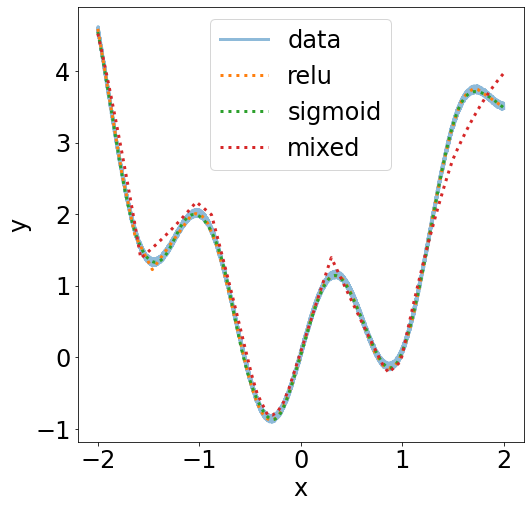

In [7]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",label = "relu")
ax.plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",label = "sigmoid")
ax.plot(x,y_predict_mixed,linewidth = 3.0,linestyle="dotted",label = "mixed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

## Formulating a Pyomo model with OMLT
We now show how OMLT can formulate our neural networks in Pyomo. We specifically show how to use OMLT to specify different optimization formulations using neural networks and we solve a corresponding minimization problem that minimizes the output of each network.

We begin by instantiating a Pyomo `ConcreteModel` and create variables that represent our neural network input `x` and output `y`. We also create an objective function that seeks to minimize the output `y`.

In [44]:
model = pyo.ConcreteModel()
model.x = pyo.Var()
model.y = pyo.Var()
model.obj = pyo.Objective(expr=(model.y))

Multiple neural network formulations are possible. These include: <br>
`FullSpaceContinuousFormulation`<br> 
`ReducedSpaceContinuousFormulation`<br> 
`ReLUBigMFormulation` <br> 
`ReLUComplementarityFormulation`

## NeuralNetworkFormulations 
OMLT can formulate neural networks using full-space or reduced-space modes.

### Reduced Space  (supports smooth activations) <br>
The reduced-space provided by OMLT hides intermediate neural network variables and activation functions from the Pyomo optimizer. This is done by formulating the neural network in Pyomo as a single constraint given by the following expression.

$\hat{y} = N(x)$


### Full Space (supports smooth and non-smooth activations) <br>
The full space formulation presents intermediate variables associated with the neural network nodes and activation functions to the optimizer. 

$x = z_0$ <br>
$\hat z_i = \sum_{j{=}1}^N w_{ij} z_j + b_i \ \forall i \in N$ <br>
$ z_i = \sigma(\hat z) \ \ \  \forall i \in N$ <br>
$y = z_N$


### Representing ReLU with Binary Variables
The full space formulation can be extended to formulate ReLU activation functions using binary variables.
TODO

### Representing ReLU with Complementarity Constraints
ReLU activation functions can also be represented using complementarity constraints.
TODO

## Setup scaling and input bounds for OMLT
With OMLT, we need to include scaling information and input bounds to maintain correctness of the optimization problem. 

In [11]:
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

input_bounds=[(min(df['x']),max(df['x']))];

In [10]:
net_relu = keras_reader.load_keras_sequential(model1,scaler,input_bounds)
model.nn = OmltBlock()
formulation = NeuralNetworkFormulation(net,
                activation_constraints={"relu": ComplementarityReLUActivation()})
model.nn.build_formulation(formulation)

#query inputs and outputs, as well as scaled inputs and outputs
model.nn.inputs_list.pprint()
model.nn.outputs_list.pprint()
model.nn.scaled_inputs_list.pprint()
model.nn.scaled_outputs_list.pprint()

n_inputs: 1


TypeError: __init__() got an unexpected keyword argument 'input_bounds'

### Solving the Pyomo Models
Now we solve an inverse problem over the neural network to find an input that produces the desired output <br>
$\min \ \hat{y}$ <br>
$s.t. \hat{y} = N(x)$

### Model 1:
- Neural Network with ReLU activations <br>
- Activations formulated using complementarity conditions

In [69]:
solutions = [] #store solutions for each model
net_relu = keras_reader.load_keras_sequential(model1,scaler,input_bounds)
model.nn = OmltBlock()
formulation = NeuralNetworkFormulation(net,activation_constraints={
            "relu": ComplementarityReLUActivation()})
model.nn.build_formulation(formulation)

@model.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.scaled_inputs[0]

@model.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status = pyo.SolverFactory('ipopt').solve(model, tee=True)
print((pyo.value(model.x),pyo.value(model.y)))
solutions.append((pyo.value(model.x),pyo.value(model.y)))

n_inputs: 1
    'pyomo.core.base.block._ScalarOmltBlock'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.block._ScalarOmltBlock'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.13.3: 

*****************************************************************

  73  3.6344012e-01 9.89e-02 5.26e+05  -1.0 1.91e+00    -  1.98e-03 7.94e-01f  1
  74  4.6433679e-01 3.17e-03 3.06e+05  -1.0 5.97e-01   0.0 6.15e-01 9.90e-01h  1
  75  4.5113754e-01 3.50e-05 1.77e+05  -1.0 4.31e-02  -0.5 9.27e-01 1.00e+00h  1
  76  3.7383633e-01 1.99e-03 3.53e+06  -1.0 1.99e+00    -  6.25e-01 1.47e-01f  3
  77  2.9481436e-01 3.62e-03 5.73e+06  -1.0 1.86e+00    -  1.00e+00 1.56e-01f  3
  78  8.7970205e-02 3.03e-03 8.28e-02  -1.0 6.08e-01    -  1.00e+00 1.00e+00F  1
  79 -2.4368621e-01 2.20e-02 9.84e+05  -3.8 2.95e+00    -  2.94e-01 3.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -5.6776715e-01 4.14e-02 4.06e+06  -3.8 1.19e+00    -  4.32e-01 1.00e+00h  1
  81 -7.9956489e-01 4.00e-02 3.14e+06  -3.8 1.20e+00    -  2.20e-01 1.00e+00h  1
  82 -8.2035782e-01 4.52e-03 1.38e+06  -3.8 4.56e-01    -  5.61e-01 1.00e+00h  1
  83 -8.7100829e-01 5.81e-03 3.54e+05  -3.8 5.73e-01    -  7.42e-01 1.00e+00h  1
  84 -8.7387763e-01 4.63e-03

### Model 2
Full-space formulation with smooth sigmoid activation functions 

In [71]:
net_sigmoid = keras_reader.load_keras_sequential(model2,scaler,input_bounds)
model.nn = OmltBlock()

formulation = NeuralNetworkFormulation(net_sigmoid)
#model.nn.build_formulation(formulation,input_vars=[model.x],output_vars=[model.y])
model.nn.build_formulation(formulation)

@model.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.scaled_inputs[0]

@model.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status = pyo.SolverFactory('ipopt').solve(model, tee=True)
solutions.append((pyo.value(model.x),pyo.value(model.y)))
print((pyo.value(model.x),pyo.value(model.y)))

n_inputs: 1
    'pyomo.core.base.block._ScalarOmltBlock'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.block._ScalarOmltBlock'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.13.3: 

*****************************************************************

  74  4.6433679e-01 3.17e-03 3.06e+05  -1.0 5.97e-01   0.0 6.15e-01 9.90e-01h  1
  75  4.5113754e-01 3.50e-05 1.77e+05  -1.0 4.31e-02  -0.5 9.27e-01 1.00e+00h  1
  76  3.7383633e-01 1.99e-03 3.53e+06  -1.0 1.99e+00    -  6.25e-01 1.47e-01f  3
  77  2.9481436e-01 3.62e-03 5.73e+06  -1.0 1.86e+00    -  1.00e+00 1.56e-01f  3
  78  8.7970205e-02 3.03e-03 8.28e-02  -1.0 6.08e-01    -  1.00e+00 1.00e+00F  1
  79 -2.4368621e-01 2.20e-02 9.84e+05  -3.8 2.95e+00    -  2.94e-01 3.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -5.6776715e-01 4.14e-02 4.06e+06  -3.8 1.19e+00    -  4.32e-01 1.00e+00h  1
  81 -7.9956489e-01 4.00e-02 3.14e+06  -3.8 1.20e+00    -  2.20e-01 1.00e+00h  1
  82 -8.2035782e-01 4.52e-03 1.38e+06  -3.8 4.56e-01    -  5.61e-01 1.00e+00h  1
  83 -8.7100829e-01 5.81e-03 3.54e+05  -3.8 5.73e-01    -  7.42e-01 1.00e+00h  1
  84 -8.7387763e-01 4.63e-03 2.19e+04  -3.8 3.93e-01    -  9.38e-01 1.00e+00h  1
  85 -8.6610010e-01 9.59e-05

### Model 3
- Full-space neural network with mixed ReLU and Sigmoid activation functions
- ReLU activations use complementarity conditions to facilitate the mixed problem

In [72]:
net_mixed = keras_reader.load_keras_sequential(model3,scaler,input_bounds)
model.nn = OmltBlock()
formulation = NeuralNetworkFormulation(net,activation_constraints={
            "relu": ComplementarityReLUActivation()})
model.nn.build_formulation(formulation)

@model.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.scaled_inputs[0]

@model.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status = pyo.SolverFactory('ipopt').solve(model, tee=True)
solutions.append((pyo.value(model.x),pyo.value(model.y)))
print((pyo.value(model.x),pyo.value(model.y)))

n_inputs: 1
    'pyomo.core.base.block._ScalarOmltBlock'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.block._ScalarOmltBlock'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.13.3: 

*****************************************************************

  75  4.5113754e-01 3.50e-05 1.77e+05  -1.0 4.31e-02  -0.5 9.27e-01 1.00e+00h  1
  76  3.7383633e-01 1.99e-03 3.53e+06  -1.0 1.99e+00    -  6.25e-01 1.47e-01f  3
  77  2.9481436e-01 3.62e-03 5.73e+06  -1.0 1.86e+00    -  1.00e+00 1.56e-01f  3
  78  8.7970205e-02 3.03e-03 8.28e-02  -1.0 6.08e-01    -  1.00e+00 1.00e+00F  1
  79 -2.4368621e-01 2.20e-02 9.84e+05  -3.8 2.95e+00    -  2.94e-01 3.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -5.6776715e-01 4.14e-02 4.06e+06  -3.8 1.19e+00    -  4.32e-01 1.00e+00h  1
  81 -7.9956489e-01 4.00e-02 3.14e+06  -3.8 1.20e+00    -  2.20e-01 1.00e+00h  1
  82 -8.2035782e-01 4.52e-03 1.38e+06  -3.8 4.56e-01    -  5.61e-01 1.00e+00h  1
  83 -8.7100829e-01 5.81e-03 3.54e+05  -3.8 5.73e-01    -  7.42e-01 1.00e+00h  1
  84 -8.7387763e-01 4.63e-03 2.19e+04  -3.8 3.93e-01    -  9.38e-01 1.00e+00h  1
  85 -8.6610010e-01 9.59e-05 3.08e-05  -3.8 5.27e-02    -  1.00e+00 1.00e+00h  1
  86 -8.6595617e-01 1.69e-06

In [73]:
print(solutions)

[(-0.24357014485612447, -0.8659535741106134), (-0.24357014485612452, -0.865953574110613), (-0.24357014485612455, -0.8659535741106135), (-0.24357014485612452, -0.8659535741106136)]


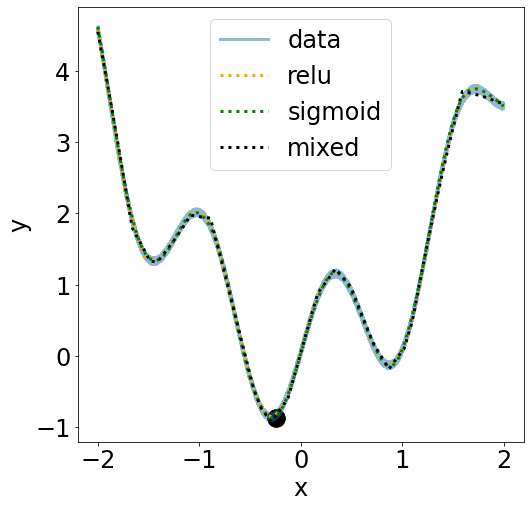

In [75]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",label = "relu",color = "orange")
ax.plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",label = "sigmoid",color = "green")
ax.plot(x,y_predict_mixed,linewidth = 3.0,linestyle="dotted",label = "mixed", color = "black")
ax.scatter([solutions[0][0]],[solutions[0][1]],color = "orange",s = 300)
ax.scatter([solutions[1][0]],[solutions[2][1]],color = "green",s = 300)
ax.scatter([solutions[2][0]],[solutions[2][1]],color = "black",s = 300)

plt.xlabel("x")
plt.ylabel("y")
plt.legend();

### Model 4
- ReLU neural network formulated using BigM with binary decisions
- Attains global solution using Cbc

In [76]:
net_relu = keras_reader.load_keras_sequential(model1,scaler,input_bounds)
model.nn = OmltBlock()
formulation = NeuralNetworkFormulation(net_relu)
model.nn.build_formulation(formulation)

@model.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.scaled_inputs[0]

@model.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status = pyo.SolverFactory('cbc').solve(model, tee=True)
solutions.append((pyo.value(model.x),pyo.value(model.y)))
print((pyo.value(model.x),pyo.value(model.y)))

n_inputs: 1
    'pyomo.core.base.block._ScalarOmltBlock'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.block._ScalarOmltBlock'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr  7 2020 

comman

(-0.23859552, -0.85632722)


In [77]:
solutions

[(-0.24357014485612447, -0.8659535741106134),
 (-0.24357014485612452, -0.865953574110613),
 (-0.24357014485612455, -0.8659535741106135),
 (-0.24357014485612452, -0.8659535741106136),
 (-0.23859552, -0.85632722)]

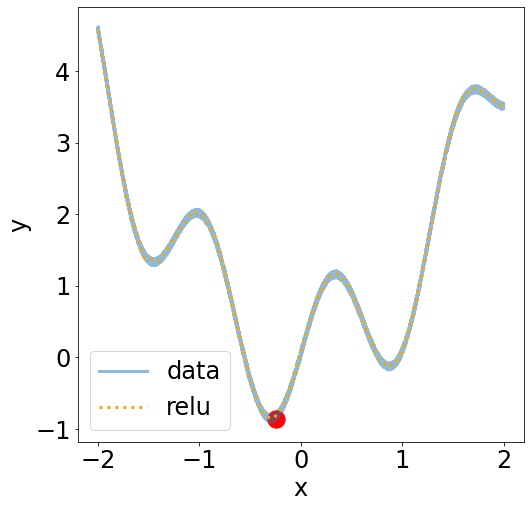

In [78]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",label = "relu",color = "orange")
ax.scatter([solutions[3][0]],[solutions[3][1]],color = "red",s = 300)

plt.xlabel("x")
plt.ylabel("y")
plt.legend();